<a href="https://www.cognitiveclass.ai"><img src = "https://cognitiveclass.ai/wp-content/themes/bdu3.0/static/images/cc-logo.png" align = left></a>

<br>
<br>

--------------------
# SETI CNN using TF and Binary DS

In [1]:
import sys
sys.path.insert(0, "/opt/DL/tensorflow/lib/python2.7/site-packages/")
import requests
import json
#import ibmseti
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pickle
import time
#!sudo pip install sklearn
import os
from sklearn.metrics import confusion_matrix
from sklearn import metrics

### Set your team folder

In [2]:
### SET YOUR TEAM NAME HERE! Use this folder to save intermediate results
team_name = 'p9_launch'
mydatafolder = os.path.join( os.environ['PWD'], team_name )  #Change my_data_folder to your team name
if os.path.exists(mydatafolder) is False:
    os.makedirs(mydatafolder)
print mydatafolder

/home/fbarilla/SETI/ML4SETI/tutorials/p9_launch


### Import dataset reader
The following cell will load a python code to read the SETI dataset.

In [3]:
!wget --output-document SETI.zip  https://ibm.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
!unzip -o SETI.zip
import SETI

--2017-08-02 14:15:19--  https://ibm.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
Resolving ibm.box.com (ibm.box.com)... 107.152.26.197, 107.152.27.197
Connecting to ibm.box.com (ibm.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip [following]
--2017-08-02 14:15:20--  https://ibm.ent.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
Resolving ibm.ent.box.com (ibm.ent.box.com)... 107.152.27.211, 107.152.26.211
Connecting to ibm.ent.box.com (ibm.ent.box.com)|107.152.27.211|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/ulUOfb6R5z82NuJFWhri0SYW7hA4LBTE6j90q7qNE2qVR14gvO-lpA77groez0RFKA-a2etoVYtyIGCttNzNocBTCEQc_OO5-MXDMdggsniaH7KFthdIrtuZMZnjr_wLQF6h3h3yDf0s162jrwMOWPIEn44jepldG64m3cWkEOq_-oMlzaZYWeUgK-4YhOXD-HkJhzlzbt6-QBPB9b4eQgCFQbb2kYZd6W-C_VzpRdU3wO4lcXlO080yF

### Download data

In [4]:
ds_directory = mydatafolder + '/SETI/SETI_ds_64x128/'


In [5]:
print os.popen("ls -lrt "+ ds_directory).read() # to verify

total 19932
-rw-r--r-- 1 root root      128 Aug  1 18:41 train-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 14478040 Aug  1 18:41 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root      112 Aug  1 18:41 test-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root  5921051 Aug  1 18:41 test-images-idx3-ubyte.gz



### Load data SETI

In [6]:
#from tensorflow.examples.tutorials.mnist import input_data
#dataset = input_data.read_data_sets("MNIST_data/", one_hot=True)
dataset = SETI.read_data_sets(ds_directory, one_hot=True, validation_size=0)
dataset.train.images.shape

Extracting /home/fbarilla/SETI/ML4SETI/tutorials/p9_launch/SETI/SETI_ds_64x128/train-images-idx3-ubyte.gz
Extracting /home/fbarilla/SETI/ML4SETI/tutorials/p9_launch/SETI/SETI_ds_64x128/train-labels-idx1-ubyte.gz
Extracting /home/fbarilla/SETI/ML4SETI/tutorials/p9_launch/SETI/SETI_ds_64x128/test-images-idx3-ubyte.gz
Extracting /home/fbarilla/SETI/ML4SETI/tutorials/p9_launch/SETI/SETI_ds_64x128/test-labels-idx1-ubyte.gz


(2840, 8192)

## Network Parameters

In [7]:
# Parameters
decay_rate=0.96
decay_steps=1000
learning_rate = 0.005
training_epochs = 200
batch_size = 50
display_step = 100

#check point directory
chk_directory = mydatafolder+'/save/'
checkpoint_path = chk_directory+'model.ckpt'


n_classes = 4 # number of possible classifications for the problem
dropout = 0.50 # Dropout, probability to keep units

height = 64 # height of the image in pixels 
width = 128 # width of the image in pixels 
n_input = width * height # number of pixels in one image 


### Inputs

In [8]:
x  = tf.placeholder(tf.float32, shape=[None, n_input])
y_ = tf.placeholder(tf.float32, shape=[None, n_classes])

In [9]:
x_image = tf.reshape(x, [-1,height,width,1]) 
x_image

<tf.Tensor 'Reshape:0' shape=(?, 64, 128, 1) dtype=float32>

#### Convolutional Layer 1

In [10]:
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32])) # need 32 biases for 32 outputs
convolve1 = tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1
h_conv1 = tf.nn.relu(convolve1)
conv1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') #max_pool_2x2
conv1

<tf.Tensor 'MaxPool:0' shape=(?, 32, 64, 32) dtype=float32>

#### Convolutional Layer 2

In [11]:
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64])) #need 64 biases for 64 outputs
convolve2= tf.nn.conv2d(conv1, W_conv2, strides=[1, 1, 1, 1], padding='SAME')+ b_conv2
h_conv2 = tf.nn.relu(convolve2)
conv2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 4, 4, 1], padding='SAME') #max_pool_2x2
conv2

<tf.Tensor 'MaxPool_1:0' shape=(?, 8, 16, 64) dtype=float32>

#### Convolutional Layer 3

#### Convolutional Layer 4

#### Fully Connected Layer 1

In [12]:
input_layer = conv2
dim = input_layer.get_shape().as_list()
dim

[None, 8, 16, 64]

In [13]:
dims= dim[1]*dim[2]*dim[3]
nodes1 = 1024
prv_layer_matrix = tf.reshape(input_layer, [-1, dims])
W_fc1 = tf.Variable(tf.truncated_normal([dims, nodes1], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[nodes1])) # need 1024 biases for 1024 outputs
h_fcl1  = tf.matmul(prv_layer_matrix, W_fc1) + b_fc1
fc_layer1 = tf.nn.relu(h_fcl1) # ???
fc_layer1


<tf.Tensor 'Relu_2:0' shape=(?, 1024) dtype=float32>

#### Droupout 1

In [14]:
keep_prob = tf.placeholder(tf.float32)
layer_drop1 = tf.nn.dropout(fc_layer1, keep_prob)

#### Fully Connected Layer 2

#### Droupout 2

#### Readout Layer

In [15]:
W_fc = tf.Variable(tf.truncated_normal([nodes1, n_classes], stddev=0.1)) #1024 neurons
b_fc = tf.Variable(tf.constant(0.1, shape=[n_classes])) # 10 possibilities for classes [0,1,2,3]
fc = tf.matmul(layer_drop1, W_fc) + b_fc
y_CNN= tf.nn.softmax(fc)

#### Loss function

In [16]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_CNN, labels=y_))

#### Training


In [17]:
# Create a variable to track the global step.
global_step = tf.Variable(0, trainable=False)

# create learning_decay
lr = tf.train.exponential_decay( learning_rate,
                                 global_step,
                                 decay_steps,
                                 decay_rate, staircase=True )

In [18]:
# Use the optimizer to apply the gradients that minimize the loss
# (and also increment the global step counter) as a single training step.
optimizer = tf.train.GradientDescentOptimizer(lr)

train_op = optimizer.minimize(cross_entropy, global_step=global_step)
#train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

#### Evaluation

In [19]:
correct_prediction = tf.equal(tf.argmax(y_CNN,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Create checkpoint directory

In [20]:
directory = os.path.dirname(chk_directory)
try:
    os.stat(directory)
    ckpt = tf.train.get_checkpoint_state(chk_directory)
    print ckpt
except:
    os.mkdir(directory) 

## Training

In [21]:
# Initializing the variables
init = tf.global_variables_initializer()

In [22]:
loss_values = []
with tf.Session() as sess:

    
    X_test = dataset.test.images
    y_test = dataset.test.labels
    sess.run(init)
    saver = tf.train.Saver(tf.global_variables())
    
    # load previously trained model if appilcable
    ckpt = tf.train.get_checkpoint_state(chk_directory)
    if ckpt:
        print "loading model: ",ckpt.model_checkpoint_path
        #saver.restore(sess, ckpt.model_checkpoint_path)
    
    
    #step = 0
    num_examples = dataset.train.num_examples
    # Training cycle
    for epoch in range(training_epochs):
        avg_loss = 0.
        avg_accuracy = 0.
        #dataset.shuffle_data()
        total_batch = int(num_examples / batch_size)

        # Loop over all batches
        start = time.time()
        for step in range(total_batch):
            x_batch, y_batch = dataset.train.next_batch(batch_size,shuffle=True)
            train_op.run(feed_dict={x: x_batch, y_: y_batch, keep_prob: dropout})
            loss, acc = sess.run([cross_entropy, accuracy], feed_dict={x: x_batch,y_: y_batch,keep_prob: 1.})
            
            avg_loss += loss / total_batch
            avg_accuracy += acc / total_batch
            if step % display_step == 1000:

                
                # Calculate batch loss and accuracy
                loss, acc = sess.run([cross_entropy, accuracy], feed_dict={x: x_batch,y_: y_batch,keep_prob: 1.})
                #train_accuracy = accuracy.eval(feed_dict={x:x_batch, y_: y_batch,  keep_prob: 0.5})

                test_accuracy = sess.run(accuracy, feed_dict={x: X_test[0:100], y_: y_test[0:100], keep_prob: 1.})

                print("Iter " + str(step) + \
                    ", Minibatch Loss= " +  "{:.6f}".format(loss) +  \
                    ", Training Accuracy= " + "{:.5f}".format(acc)  + \
                    ", Test Accuracy= " + "{:.5f}".format(test_accuracy) )
        
        # save model every 1 epochs
        if epoch >= 0 and epoch % 1 == 0:
            # Save model
            #print ("model saved to {}".format(checkpoint_path))
            #saver.save(sess, checkpoint_path, global_step = epoch)
            end = time.time()
            plr = sess.run(lr)
            loss_values.append(avg_loss)
            #print(sess.run(tf.train.global_step()))
            print "Epoch:", '%04d' % (epoch+1) , ", Epoch time=" , "{:.5f}".format(end - start) , ", lr=", "{:.9f}".format(plr), ", cost=", "{:.9f}".format(avg_loss) ,", Acc=", "{:.9f}".format(avg_accuracy)

    print("Optimization Finished!")
    print ("model saved to {}".format(checkpoint_path))
    saver.save(sess, checkpoint_path, global_step = (epoch+1)*step)

    
    
    # Calculate accuracy for test images
    #print("Testing Accuracy:", sess.run(accuracy, feed_dict={x: X_test[0:30], y_: y_test[0:30], keep_prob: 1.}))
        
    # Find the labels of test set
    y_pred_lb = sess.run(tf.argmax(y_CNN,1), feed_dict={x: X_test[0:100], y_: y_test[0:100], keep_prob: 1.})
    y_pred = sess.run(y_CNN, feed_dict={x: X_test[0:100], y_: y_test[0:100], keep_prob: 1.})
    
    # lets save kernels
    kernels_l1 = sess.run(tf.reshape(tf.transpose(W_conv1, perm=[2, 3, 0, 1]),[32,-1]))
    kernels_l2 = sess.run(tf.reshape(tf.transpose(W_conv2, perm=[2, 3, 0, 1]),[32*64,-1]))

Epoch: 0001 , Epoch time= 5.73316 , lr= 0.005000000 , cost= 1.472581346 , Acc= 0.251785704
Epoch: 0002 , Epoch time= 3.10942 , lr= 0.005000000 , cost= 1.493209971 , Acc= 0.249999992
Epoch: 0003 , Epoch time= 3.10705 , lr= 0.005000000 , cost= 1.496168388 , Acc= 0.247499993
Epoch: 0004 , Epoch time= 3.11653 , lr= 0.005000000 , cost= 1.490673582 , Acc= 0.250714279
Epoch: 0005 , Epoch time= 3.14756 , lr= 0.005000000 , cost= 1.484942492 , Acc= 0.252142848
Epoch: 0006 , Epoch time= 3.10891 , lr= 0.005000000 , cost= 1.490040462 , Acc= 0.245714278
Epoch: 0007 , Epoch time= 3.12340 , lr= 0.005000000 , cost= 1.476300401 , Acc= 0.251428564
Epoch: 0008 , Epoch time= 3.14460 , lr= 0.005000000 , cost= 1.492142920 , Acc= 0.248571420
Epoch: 0009 , Epoch time= 3.13457 , lr= 0.005000000 , cost= 1.470588299 , Acc= 0.257142848
Epoch: 0010 , Epoch time= 3.16006 , lr= 0.005000000 , cost= 1.476666480 , Acc= 0.257142848
Epoch: 0011 , Epoch time= 3.14152 , lr= 0.005000000 , cost= 1.469826773 , Acc= 0.257499992

Epoch: 0092 , Epoch time= 3.20673 , lr= 0.004076863 , cost= 1.280954778 , Acc= 0.432142843
Epoch: 0093 , Epoch time= 3.19300 , lr= 0.004076863 , cost= 1.273394193 , Acc= 0.425714272
Epoch: 0094 , Epoch time= 3.19207 , lr= 0.004076863 , cost= 1.254613419 , Acc= 0.471428558
Epoch: 0095 , Epoch time= 3.21326 , lr= 0.004076863 , cost= 1.289066153 , Acc= 0.404285704
Epoch: 0096 , Epoch time= 3.20969 , lr= 0.004076863 , cost= 1.276693319 , Acc= 0.441785699
Epoch: 0097 , Epoch time= 3.22082 , lr= 0.004076863 , cost= 1.288118384 , Acc= 0.397857134
Epoch: 0098 , Epoch time= 3.20868 , lr= 0.004076863 , cost= 1.258175318 , Acc= 0.445357124
Epoch: 0099 , Epoch time= 3.23232 , lr= 0.004076863 , cost= 1.295647223 , Acc= 0.409642843
Epoch: 0100 , Epoch time= 3.21823 , lr= 0.004076863 , cost= 1.271354245 , Acc= 0.444642840
Epoch: 0101 , Epoch time= 3.22422 , lr= 0.004076863 , cost= 1.273052554 , Acc= 0.429642845
Epoch: 0102 , Epoch time= 3.22031 , lr= 0.004076863 , cost= 1.275086352 , Acc= 0.421428558

Epoch: 0183 , Epoch time= 3.23333 , lr= 0.003324162 , cost= 1.140554639 , Acc= 0.576428554
Epoch: 0184 , Epoch time= 3.22250 , lr= 0.003324162 , cost= 1.116410206 , Acc= 0.609642846
Epoch: 0185 , Epoch time= 3.24983 , lr= 0.003324162 , cost= 1.143819648 , Acc= 0.566428557
Epoch: 0186 , Epoch time= 3.23771 , lr= 0.003324162 , cost= 1.116457007 , Acc= 0.609999984
Epoch: 0187 , Epoch time= 3.22578 , lr= 0.003324162 , cost= 1.124123169 , Acc= 0.596071414
Epoch: 0188 , Epoch time= 3.22800 , lr= 0.003324162 , cost= 1.129657918 , Acc= 0.576785699
Epoch: 0189 , Epoch time= 3.24936 , lr= 0.003324162 , cost= 1.125935653 , Acc= 0.588214269
Epoch: 0190 , Epoch time= 3.24245 , lr= 0.003324162 , cost= 1.130044471 , Acc= 0.595714270
Epoch: 0191 , Epoch time= 3.25784 , lr= 0.003324162 , cost= 1.111718526 , Acc= 0.604285696
Epoch: 0192 , Epoch time= 3.24001 , lr= 0.003324162 , cost= 1.133696066 , Acc= 0.588571415
Epoch: 0193 , Epoch time= 3.23585 , lr= 0.003324162 , cost= 1.114507504 , Acc= 0.608571411

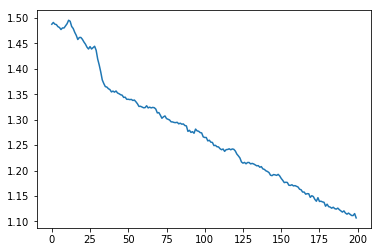

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.plot([np.mean(loss_values[i:i+5]) for i in range(len(loss_values))])
plt.show()


## Evaluation

Accuracy is depend on the number of epoch that you set in partametrs part.

In [24]:
y_ = np.argmax(y_test[0:100],1) # ground truth
print metrics.classification_report(y_true= y_, y_pred= y_pred_lb)
print metrics.confusion_matrix(y_true= y_, y_pred= y_pred_lb)
print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_true= y_, y_pred= y_pred_lb) )
print("Log Loss: %0.6f" % metrics.log_loss(y_true= y_, y_pred= y_pred, labels=range(4)) )

             precision    recall  f1-score   support

          0       0.77      0.43      0.56        23
          1       1.00      0.24      0.39        33
          2       0.00      0.00      0.00         0
          3       0.94      1.00      0.97        44

avg / total       0.92      0.62      0.68       100

[[10  0 10  3]
 [ 3  8 22  0]
 [ 0  0  0  0]
 [ 0  0  0 44]]
Classification accuracy: 0.620000
Log Loss: 0.889025


/root/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Generate CSV file for Scoreboard

Here's an example of what the CSV file should look like for submission to the scoreboard. Although, in this case, we only have 4 classes instead of 7.

#### NOTE: This uses the test set created in Step_5c, which only contain the BASIC4 test data set. The code challenge and hackathon will be based on the Primary Data Set which contains 7 signal classes, and different test set.

In [25]:
my_output_results = mydatafolder + '/' + 'DL_scores.csv'
with open(my_output_results, 'w') as csvfile:
    np.savetxt(my_output_results, y_pred, delimiter=",")

In [26]:
print os.popen("ls -lrt "+ mydatafolder).read() # to verify

total 20
drwxr-xr-x 3 root root  4096 Aug  1 18:41 SETI
drwxr-xr-x 2 root root  4096 Aug  2 14:28 save
-rw-r--r-- 1 root root 10000 Aug  2 14:37 DL_scores.csv



### Viz

In [27]:
!wget --output-document utils1.py http://deeplearning.net/tutorial/code/utils.py
import utils1
from utils1 import tile_raster_images

--2017-08-02 14:37:45--  http://deeplearning.net/tutorial/code/utils.py
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5097 (5.0K) [text/plain]
Saving to: ‘utils1.py’

utils1.py           100%[===================>]   4.98K  --.-KB/s    in 0s      

2017-08-02 14:37:46 (941 MB/s) - ‘utils1.py’ saved [5097/5097]



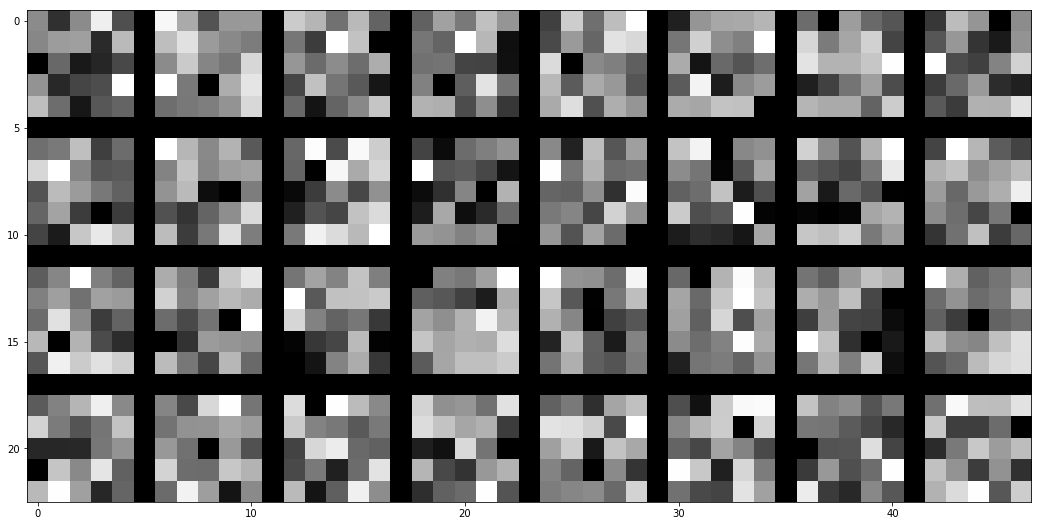

In [28]:
#from utils import tile_raster_images
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(kernels_l1, img_shape=(5, 5) ,tile_shape=(4, 8), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

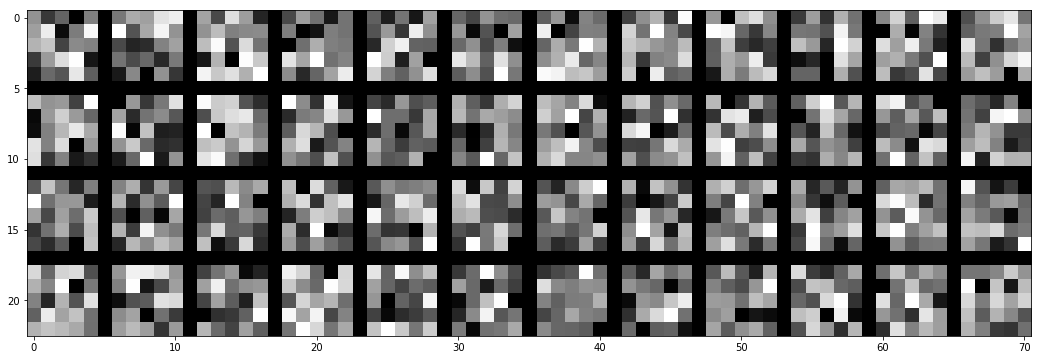

In [29]:
image = Image.fromarray(tile_raster_images(kernels_l2, img_shape=(5, 5) ,tile_shape=(4, 12), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

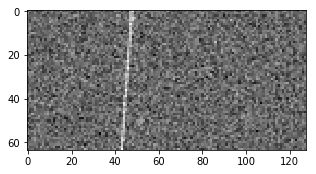

In [30]:
import numpy as np
plt.rcParams['figure.figsize'] = (5.0, 5.0)
sampleimage1 = X_test[3]
plt.imshow(np.reshape(sampleimage1,[64,128]), cmap="gray")

Instructions for updating:
Please use tf.global_variables instead.
loading model:  /home/fbarilla/SETI/ML4SETI/tutorials/p9_launch/save/model.ckpt-11000


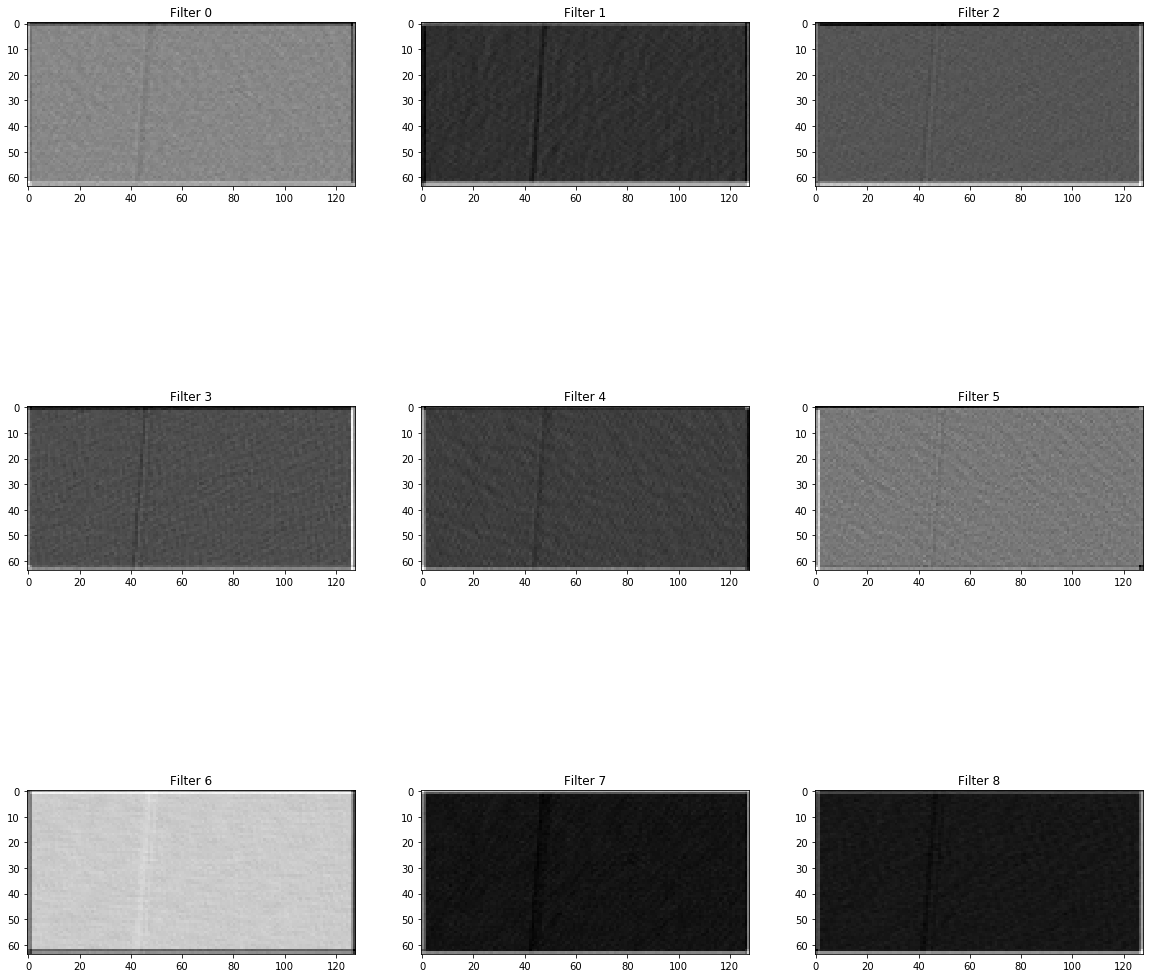

In [31]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    saver = tf.train.Saver(tf.all_variables())
    
    # load previously trained model if appilcable
    ckpt = tf.train.get_checkpoint_state(chk_directory)
    if ckpt:
        print "loading model: ",ckpt.model_checkpoint_path
        saver.restore(sess, ckpt.model_checkpoint_path)
    ActivatedUnits1 = sess.run(convolve1,feed_dict={x:np.reshape(sampleimage1,[1,64*128],order='F'),keep_prob:1.0})
    plt.figure(1, figsize=(20,20))
    n_columns = 3
    n_rows = 3
    for i in range(9):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(ActivatedUnits1[0,:,:,i], interpolation="nearest", cmap="gray")

### Authors

<div class="teacher-image" style="    float: left;
    width: 115px;
    height: 115px;
    margin-right: 10px;
    margin-bottom: 10px;
    border: 1px solid #CCC;
    padding: 3px;
    border-radius: 3px;
    text-align: center;"><img class="alignnone wp-image-2258 " src="https://ibm.box.com/shared/static/tyd41rlrnmfrrk78jx521eb73fljwvv0.jpg" alt="Saeed Aghabozorgi" width="178" height="178" /></div>
#### Saeed Aghabozorgi

[Saeed Aghabozorgi](https://ca.linkedin.com/in/saeedaghabozorgi), PhD is Sr. Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

